In [1]:
import json
import os
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

import argparse
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader


from Utilities import score
from Utilities import plot_matrix_runs, plot_results, save_plot_losses
from Utilities import Add_ID_Count_Neighbours, PairData, prepare_dataloader_distance_scale

from training import training_loop

from models import GCN_k_m, GCN3

In [2]:
# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Load dataset
dataset = TUDataset(root='/tmp/ENZYMES_transformed', name='ENZYMES', pre_transform=Add_ID_Count_Neighbours(), use_node_attr=True)

In [9]:
# Load the homomorphism counts vectors:
name_dataset = 'ENZYMES'
n_homs=44
hom_counts_path = 'data/homomorphism_counts/' + name_dataset + "_" + str(n_homs) + ".homson"
if not os.path.exists(hom_counts_path):
    raise FileNotFoundError(f"The file '{hom_counts_path}' was not found.")

# Load dataset
dataset = TUDataset(root='/tmp/MUTAG_transformed', name='MUTAG', pre_transform=Add_ID_Count_Neighbours(), use_node_attr=True)

In [158]:
# torch.manual_seed(args.seed)
batch_size = 32
distance = 'L2'
distance_scaling = 'counts_density'
train_loader, val_loader, test_loader = prepare_dataloader_distance_scale(hom_counts_path, dataset, batch_size=batch_size, dist=distance, device = device, scaling = distance_scaling, scale_y=False)

In [163]:
# Prepare the model:
hid_size = 32
emb_size = n_homs
lr = 0.1
name = 'GCN3'
model = GCN3(input_features=dataset.num_node_features, hidden_channels=hid_size, output_embeddings=emb_size, name=name, dist=distance).to(device)
# model = GCN3(input_features=dataset.num_node_features, hidden_channels=hid_size, output_embeddings=emb_size, n_conv_layers=2, n_linear_layers=1, p=0.2, name = name, apply_relu_conv=False, dist='cosine', mlp_dist=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss().to(device)

In [164]:
print(model)

GCN3(
  (conv1): GCNConv(1, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (lin): Linear(in_features=32, out_features=44, bias=True)
  (pdist): PairwiseDistance()
)


In [114]:
train_losses, validation_losses = training_loop(model, train_loader, optimizer, criterion, val_loader, epoch_number=20, patience=10, return_losses=True)

Epoch: 10 | Time for 10 epochs: 0m 30s
	Train Loss: 0.015
	 Val. Loss: 0.001
Early stopping triggered at epoch 13
Best epoch was 2


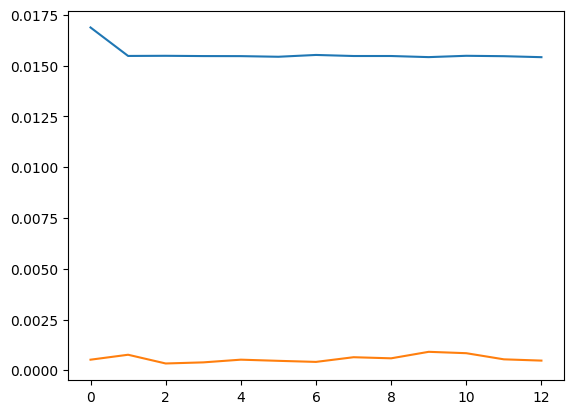

In [115]:
plt.plot(train_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.show()